## Overview

In this notebook, we create, train, and evaluate a densenet convolutional neural network for predicting events of 
interest in images.

In [1]:
"""Imports."""

from pathlib import Path
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision import models, transforms

In [2]:
"""Specify which device (CPU or GPU) to use"""

if torch.cuda.is_available():  # if we have a GPU and its available to pytorch, use it
    device = torch.device("cuda")
    print(f"Using GPU device: {torch.cuda.get_device_name(device)}\n")
else:  # else, use cpu
    device = torch.device("cpu")
    print("Using CPU.\n")

Using GPU device: NVIDIA GeForce RTX 3090



In [3]:
"""Initialize target outputs: read our labels from a file and convert them to a 2-d tensor."""

labels_path = Path(r"C:\Users\jai\veo_nu\data\labels\Initial_combined_labels.csv")  # path to labels file
labels_df = pd.read_csv(labels_path)  # read the labels file into a pandas dataframe table
display(labels_df.head())  # display the first few rows of the labels dataframe

,Frame,Possession,Set piece
0,410,1,0
1,420,1,0
2,430,1,0
3,440,1,0
4,450,1,0


In [4]:
Y = labels_df[["Possession", "Set piece"]].values  # extract the "Possession" and "Set piece" values
Y = torch.from_numpy(Y).float().to(device)  # convert the extracted values to a 2-d tensor
print(Y.shape)  # print the shape of the initialized target outputs
N, n_classes = Y.shape[0], Y.shape[1]  # number of samples, number of classes

torch.Size([680, 2])


In [5]:
"""Initialize inputs: convert the frame images to a list of 3-d tensors (width X height X rgb)."""

frames_path = Path(r"C:\Users\jai\veo_nu\data\initial_combined_frames")  # path to image directory
n_channels, height, width = 3, 224, 224  # initialize the dimensions of the frames
X = torch.empty((N, n_channels, height, width))  # initialize a tensor that will store all frames
print(X.shape)  # print shape of initialized inputs

torch.Size([680, 3, 224, 224])


In [6]:
"""Fill in `X` frame-by-frame."""

for i, file in enumerate(frames_path.glob("*.png")):  # find each image file in `frames_path` directory
    with Image.open(file).convert("RGB") as img:  # open the image file and convert to RGB
        to_tensor = transforms.ToTensor()  # initialize a ToTensor conversion object
        resize = transforms.Resize((height, width))  # initialize a Resize object
        img_tensor = to_tensor(img).float()  # use the ToTensor object to convert the image to a tensor (will be normalized pixel values between 0-1)
        img_tensor = resize(img_tensor)  # use the Resize object to resize the tensor to the specified dimensions
        X[i, :] = img_tensor  # add the tensor of the current frame to our list of tensors

c:\Users\jai\mambaforge\envs\intro2dl\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [7]:
"""Create Datasets and DataLoader."""

# Create training, testing, and validation datasets.
dataset = TensorDataset(X, Y)
train_data, val_data = random_split(dataset, [0.90, 0.10])
# View training and validation data subsets.
print(train_data[:][0].shape, train_data[:][1].shape, val_data[:][0].shape, val_data[:][1].shape)


torch.Size([612, 3, 224, 224]) torch.Size([612, 2]) torch.Size([68, 3, 224, 224]) torch.Size([68, 2])


In [8]:
"""Create function to perform gradient centralization during training."""

def apply_gradient_centralization(optimizer):
    """Applies gradient centralization to the optimizer.
    
    This function should be called before optimizer.step() in the training loop.
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                # Compute the mean of the gradient
                grad_mean = param.grad.data.mean(dim=tuple(range(1, len(param.grad.shape))), keepdim=True)
                # Centralize the gradient
                param.grad.data -= grad_mean

In [9]:
"""Create function to train the model."""

def train(
    model: nn.Module,  # model
    train_loader: DataLoader,  # batched dataset for training
    val_loader: DataLoader,  # batched dataset for validation
    optimizer: optim,  # optimizer for performing parameter update step
    loss_fn: nn.modules.loss,  # loss function
    max_epochs: int = 5,  # max n training epochs
    val_check_interval: int = 10,  # check val loss every `val_check_interval` batches
) -> tuple[torch.Tensor, np.ndarray, np.ndarray]:  # -> loss, train_losses, val_losses
    """Trains a model, returns loss."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # set device
    train_losses, val_losses = [], []  # create trackers

    # <s Go through training and validation loop
    for epoch in range(max_epochs):  # epoch is all frames in our "train" dataset
        for batch_i, (x_train, y_train) in enumerate(train_loader):  # get train batch of frames and labels
            # <ss Model training.
            model.train()  # set model to training mode (which means it's computing gradients)
            optimizer.zero_grad()  # set all gradients to zero for the current step
            out = model(x_train.to(device))  # forward pass through the model
            loss = loss_fn(out, y_train.to(device))  # compute loss
            loss.backward()  # backward pass back through the model to compute gradients
            apply_gradient_centralization(optimizer)  # apply gradient centralization
            optimizer.step()  # update model parameters based on computed gradients
            # /ss>
            # <ss Model validation (for early stopping).
            if batch_i % val_check_interval == 0:  # every `val_check_interval` batches check val_loss and print
                train_losses.append(loss.item())  # append the current train loss to list of train losses
                model.eval()  # set model to eval mode
                with torch.no_grad():  # ensure gradients aren't computed
                    x_val, y_val = next(iter(val_loader))  # get val batch of frames and labels
                    val_out = model(x_val.to(device))
                    val_loss = loss_fn(val_out, y_val.to(device))  # compute val loss
                    val_losses.append(val_loss.item())  # append the current val loss to list of val losses
                print(  # print the current epoch, batch, train loss, and val loss
                    f"Epoch {epoch + 1}: Batch {batch_i + 1}:  "
                    f"Loss = {train_losses[-1]:.3f}, Val Loss = {val_losses[-1]:.3f}"
                )
            # /ss>
    # /s>
    print("Finished training:")
    print(f"Epoch {epoch + 1}:  Batch {batch_i + 1}: Loss = {train_losses[-1]:.3f}, Val Loss = {val_losses[-1]:.3f}")
    return loss, train_losses, val_losses

In [14]:
"""Load in initial pretrained model."""

# Load in model that was used for AlexNet
# Possible pretrained models to try: DenseNet121_Weights, DenseNet169_Weights, ResNet50_Weights, ResNet101_Weights

model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
print(model)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [15]:
"""Configure model (just change last layer in model)"""

dropout_rate = 0.2  # 20% cell removal to help with generalization

# Modify the classifier to output 2 probabilities
model.classifier = nn.Sequential(
    nn.Dropout(dropout_rate),
    nn.Linear(model.classifier.in_features, n_classes),
    nn.Sigmoid()  # Use sigmoid for binary multiclass, multilabel classification
)

In [37]:
"""Train model."""

batch_size = 32  # number of frames in each batch to process when computing loss
lr = 0.02  # learning rate: scale factor used in the parameter update step

# Create data loaders
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
# Set loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-7, momentum=0.6, nesterov=True)
# Train
loss, train_losses, val_losses = train(
    model.to(device), train_loader, val_loader, optimizer, loss_fn, max_epochs=10, val_check_interval=3
)

Epoch 1: Batch 1:  Loss = 0.094, Val Loss = 0.187
Epoch 1: Batch 4:  Loss = 0.034, Val Loss = 0.165
Epoch 1: Batch 7:  Loss = 0.062, Val Loss = 0.137
Epoch 1: Batch 10:  Loss = 0.034, Val Loss = 0.128
Epoch 1: Batch 13:  Loss = 0.026, Val Loss = 0.121
Epoch 1: Batch 16:  Loss = 0.030, Val Loss = 0.114
Epoch 1: Batch 19:  Loss = 0.039, Val Loss = 0.100
Epoch 2: Batch 1:  Loss = 0.040, Val Loss = 0.375
Epoch 2: Batch 4:  Loss = 0.029, Val Loss = 0.301
Epoch 2: Batch 7:  Loss = 0.062, Val Loss = 0.139
Epoch 2: Batch 10:  Loss = 0.028, Val Loss = 0.100
Epoch 2: Batch 13:  Loss = 0.021, Val Loss = 0.093
Epoch 2: Batch 16:  Loss = 0.022, Val Loss = 0.092
Epoch 2: Batch 19:  Loss = 0.021, Val Loss = 0.085
Epoch 3: Batch 1:  Loss = 0.052, Val Loss = 0.184
Epoch 3: Batch 4:  Loss = 0.027, Val Loss = 0.188
Epoch 3: Batch 7:  Loss = 0.051, Val Loss = 0.143
Epoch 3: Batch 10:  Loss = 0.026, Val Loss = 0.130
Epoch 3: Batch 13:  Loss = 0.022, Val Loss = 0.103
Epoch 3: Batch 16:  Loss = 0.020, Val Lo

In [38]:
# Save model
torch.save(model.state_dict(), "models/MatchMentor_Liverpool_Loss=0.002_ValLoss=0.092.pth")

In [ ]:
# Plot training and validation losses

fig, ax = plt.subplots()
ax.plot(train_losses, label="Train")
ax.plot(val_losses, label="Val")
ax.legend()
ax.set_xlabel("Batch")
ax.set_ylabel("Loss")
ax.set_title("Training and Validation Losses")


---

## End

## Everything below this is a messy scratchpad : )

In [34]:
# View val images and see how it performed

val_frame = val_data[:][0][2].unsqueeze(0)  # shape of first val image

In [20]:
model.eval()
model(val_frame.to(device))

tensor([[0.9267, 0.0136]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [21]:
val_data[:][1][0]

tensor([1., 0.], device='cuda:0')

In [22]:
_20.round()

tensor([[1., 0.]], device='cuda:0', grad_fn=<RoundBackward0>)

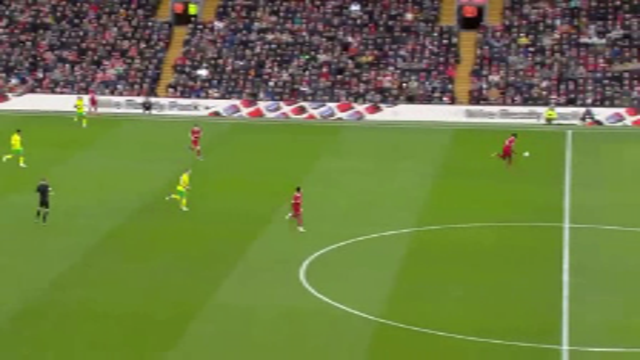

In [35]:
transforms.ToPILImage()(val_frame[0]).resize((640, 360))